# Tabular Q-Learning From Scratch

### Custom Environment to train our model on

In [1]:
import gym
from gym import spaces

import numpy as np
import random
from copy import deepcopy


class gridworld_custom(gym.Env):

    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, *args, **kwargs):
        super(gridworld_custom, self).__init__()

        self.current_step = 0

        self.reward_range = (-10, 100)

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(low=np.array(
            [0, 0]), high=np.array([4, 4]), dtype=np.int64)

        self.target_coord = (4, 4)
        self.death_coord = [(3, 1), (4, 2)]

    def Reward_Function(self, obs):

        if (obs[0] == self.target_coord[0] and obs[1] == self.target_coord[1]):
            return 20
        elif (obs[0] == self.death_coord[0][0] and obs[1] == self.death_coord[0][1]) or \
                (obs[0] == self.death_coord[1][0] and obs[1] == self.death_coord[1][1]):
            return -10
        else:
            return -1

        return 0

    def reset(self):
        self.current_step = 0

        self.prev_obs = [random.randint(0, 4), random.randint(0, 4)]

        if (self.prev_obs[0] == self.target_coord[0] and self.prev_obs[1] == self.target_coord[1]):

            return self.reset()

        return self.prev_obs

    def step(self, action):

        action = int(action)

        self.current_step += 1

        obs = deepcopy(self.prev_obs)

        if(action == 0):
            if(self.prev_obs[0] < 4):
                obs[0] = obs[0] + 1
            else:
                obs[0] = obs[0]

        if(action == 1):
            if(self.prev_obs[0] > 0):
                obs[0] = obs[0] - 1
            else:
                obs[0] = obs[0]

        if(action == 2):
            if(self.prev_obs[1] < 4):
                obs[1] = obs[1] + 1
            else:
                obs[1] = obs[1]

        if(action == 3):
            if(self.prev_obs[1] > 0):
                obs[1] = obs[1] - 1
            else:
                obs[1] = obs[1]

        reward = self.Reward_Function(obs)

        if (obs[0] == self.target_coord[0] and obs[1] == self.target_coord[1]) or (self.current_step >= 250):
            done = True
        else:
            done = False

        self.prev_obs = obs

        return obs, reward, done, {}

    def render(self, mode='human', close=False):

        for i in range(0, 5):
            for j in range(0, 5):
                if i == self.prev_obs[0] and j == self.prev_obs[1]:
                    print("*", end=" ")
                elif i == self.target_coord[0] and j == self.target_coord[1]:
                    print("w", end=" ")
                elif (i == self.death_coord[0][0] and j == self.death_coord[0][1]) or \
                     (i == self.death_coord[1][0] and j == self.death_coord[1][1]):
                    print("D", end=" ")
                else:
                    print("_", end=" ")
            print()

        print()
        print()


### Import Required Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import pandas as pd
#from tqdm.auto import tqdm
from tqdm import tqdm

### Build the q-learning class which contains the table storing all the q values for all states and actions

In [3]:
class q_learning():
    
    def __init__(self):
        self.q_table = pd.DataFrame(columns=['state', 'q_val_0', 'q_val_1', 'q_val_2', 'q_val_3'])

        for i in range(5):
            for j in range(5):
                state_str = "("+str(i)+","+str(j)+")"
                X = pd.DataFrame([[state_str, 0, 0, 0, 0]], columns=['state', 'q_val_0', 'q_val_1', 'q_val_2', 'q_val_3'])
                self.q_table = self.q_table.append(X, ignore_index=True)
        
        self.q_table = self.q_table.set_index('state')

        self.gamma = 1
        self.step_size = 0.8
    
    def update_q_value(self, curr_state, prev_state, action, reward):

        curr_state_str = "("+str(curr_state[0])+","+str(curr_state[1])+")"
        prev_state_str = "("+str(prev_state[0])+","+str(prev_state[1])+")"
        action_str = "q_val_"+str(action)

        q_pred = self.q_table.loc[prev_state_str][action_str]

        q_target = reward + self.gamma * np.max(self.q_table.loc[curr_state_str].to_numpy())

        self.q_table.loc[prev_state_str][action_str] = q_pred + self.step_size * (q_target - q_pred)

    def choose_action(self, curr_state):
        curr_state_str = "("+str(curr_state[0])+","+str(curr_state[1])+")"
        action = np.argmax(self.q_table.loc[curr_state_str].to_numpy())
        return action

#### Check up the functionality of epsilon greedy. Just for reference.

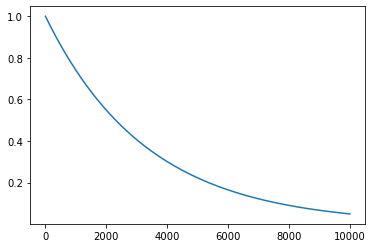

In [4]:
epsilon = 1
epsilon_decay = 0.9997

episodes = 10000
epsilon_copy = deepcopy(epsilon)
eps = []

for i in range(episodes):
    epsilon_copy = epsilon_copy * epsilon_decay
    eps.append(epsilon_copy)

plt.plot(eps)
plt.show()

### Run everything.

In [5]:
env = gridworld_custom()
agent = q_learning()


pbar = tqdm(range(episodes))

for episode in pbar:

    prev_obs = env.reset()
    done = False

    epsilon = epsilon * epsilon_decay

    while not(done):
        if(random.uniform(0, 1) > epsilon):
            action = agent.choose_action(prev_obs)
        else:
            action = random.randint(0,3)
        obs, reward, done, _ = env.step(action)
        agent.update_q_value(obs, prev_obs, action, reward)
        prev_obs = deepcopy(obs)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.64it/s]


### Take a look at the Q Table after training. Gives us an understanding as to how the model might function

In [6]:
agent.q_table

,q_val_0,q_val_1,q_val_2,q_val_3
state,,,,
"(0,0)",13.0,12.0,13.0,12.0
"(0,1)",14.0,13.0,14.0,12.0
"(0,2)",15.0,14.0,15.0,13.0
"(0,3)",16.0,15.0,16.0,14.0
"(0,4)",17.0,16.0,16.0,15.0
"(1,0)",14.0,12.0,14.0,13.0
"(1,1)",15.0,13.0,15.0,13.0
"(1,2)",16.0,14.0,16.0,14.0
"(1,3)",17.0,15.0,17.0,15.0


### Test the trained model

In [7]:
prev_obs = env.reset()
done = False
env.render()
while not(done):
    action = agent.choose_action(prev_obs)
    obs, reward, done, _ = env.step(action)
    prev_obs = obs
    env.render()

_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ _ _ 
* _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
* D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
* _ _ _ _ 
_ D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ * _ _ _ 
_ D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ * _ _ 
_ D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D * _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ * _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ _ _ 
_ _ D * w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ _ _ 
_ _ D _ * 


